# Define Encryption key

In [1]:
key = 13
vocab = [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ-']

# Encrypt Function

In [2]:
def encrypt(text):
    
    indexes = [vocab.index(char) for char in text]
    encrypted_indexes = [ (idx + key) % len(vocab) for idx in indexes]
    encrypted_chars = [vocab[idx] for idx in encrypted_indexes]
    encrypted = ''.join(encrypted_chars)
    return encrypted

In [3]:
assert encrypt('ABCDEFGHIJKLMNOPQRSTUVWXYZ-') == 'NOPQRSTUVWXYZ-ABCDEFGHIJKLM'

# Libraries Import

In [4]:
import random
import torch
import numpy as np
import torch.nn as nn
%matplotlib inline
import matplotlib.pyplot as plt

# Set Batch Size and Maximum Message length

In [5]:
num_examples = 128
message_length = 64

# Function to generate data

In [6]:
def dataset(num_examples):
    
    dataset = []
    for x in range(0, num_examples):
        ex_out = ''.join([random.choice(vocab) for x in range(message_length)])
        ex_in = encrypt(''.join(ex_out))
        ex_in = [vocab.index(x) for x in ex_in]
        ex_out = [vocab.index(x) for x in ex_out]
        dataset.append([torch.tensor(ex_in), torch.tensor(ex_out)])
        
    return dataset

# RNN Hyper - Parameters

In [7]:
embedding_dim = 5
hidden_dim = 10
vocab_size = len(vocab)

# Neural Network Architecture

In [8]:
embed = torch.nn.Embedding(vocab_size, embedding_dim)
rnn = torch.nn.RNN(embedding_dim, hidden_dim)
linear = torch.nn.Linear(hidden_dim, vocab_size)
softmax = torch.nn.functional.softmax
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(list(embed.parameters()) + list(rnn.parameters()) + list(linear.parameters()), lr=0.001)

In [9]:
def zero_hidden():
    return torch.zeros(1, 1, hidden_dim)

# Train Network

In [10]:
num_epochs = 12

accuracies, max_accuracy = [], 0
loss_list = []

In [11]:
for x in range(num_epochs):
    
    print("Epoch : %d"%(x))
    
    for encrypted, original in dataset(num_examples):
    
        rnn_in = embed(encrypted)
        rnn_in = rnn_in.unsqueeze(1)

        rnn_out, rnn_hidden = rnn(rnn_in, zero_hidden())

        scores = linear(rnn_out)
        scores = scores.transpose(1, 2)

        original = original.unsqueeze(1)
        loss = loss_fn(scores, original)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        loss_list.append(loss.item())
    
    print("Loss : %.4f"%(loss.item()))
    
    with torch.no_grad():
        
        matches, total = 0, 0
        for encrypted, original in dataset(num_examples):
            rnn_in = embed(encrypted)
            rnn_in = rnn_in.unsqueeze(1)
            rnn_out, rnn_hidden = rnn(rnn_in, zero_hidden())
            
            scores = linear(rnn_out)
            
            predictions = softmax(scores, dim=2)
            
            _, batch_out = predictions.max(dim=2)
            
            batch_out = batch_out.squeeze(1)
            
            matches += torch.eq(batch_out, original).sum().item()
            total += torch.numel(batch_out)
            
        accuracy = matches/total
        accuracies.append(accuracy)
        print("Accuracy : %.4f"%(accuracy * 100))

Epoch : 0
Loss : 2.9417
Accuracy : 26.9043
Epoch : 1
Loss : 2.3611
Accuracy : 52.5269
Epoch : 2
Loss : 1.6127
Accuracy : 76.5869
Epoch : 3
Loss : 1.1779
Accuracy : 90.2832
Epoch : 4
Loss : 0.8698
Accuracy : 92.8711
Epoch : 5
Loss : 0.6403
Accuracy : 99.8413
Epoch : 6
Loss : 0.4958
Accuracy : 100.0000
Epoch : 7
Loss : 0.3624
Accuracy : 100.0000
Epoch : 8
Loss : 0.2770
Accuracy : 100.0000
Epoch : 9
Loss : 0.2095
Accuracy : 100.0000
Epoch : 10
Loss : 0.1774
Accuracy : 100.0000
Epoch : 11
Loss : 0.1348
Accuracy : 100.0000


# Plots

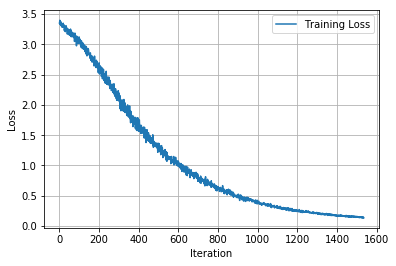

In [26]:
plt.plot(loss_list, label="Training Loss")
#plt.plot(accuracies, label="accuracy on validation data set")
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_plot.png")

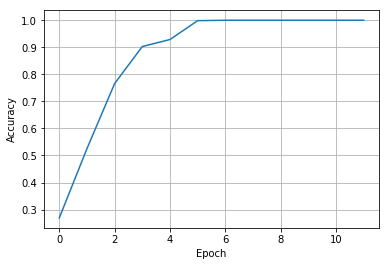

In [25]:
plt.plot(accuracies, label="Accuracy on Val. Data")
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig("acc.png")